In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import os
from read_O3_LVK_results import *

In [2]:
precomputed_data = "stored_chi_cost_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    chis = traces['chis']
    costs = traces['costs']
    f_chis = traces['f_chis']
    f_costs = traces['f_costs']
    R_ref = traces['R_ref']
    f_a01 = traces['f_a01']
    f_cost1 = traces['f_cost1']
    bq = traces['bq']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_1000_1500_noReweighting.cdf")

    # Also extract mass and mass ratio values
    chi_cost_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_chi_cost_data_1000_1500_noReweighting.npy',allow_pickle=True)[()]
    chi_values = chi_cost_data['chi_allSamples']
    cost_values = chi_cost_data['cost_allSamples']
    
    bq_values = np.concatenate([
        inference_data.posterior.bq.values[i,:]
        for i in range(inference_data.posterior.bq.shape[0])])

    chis = chi_values[::100]
    f_chis = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,::100]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    costs = cost_values[::100]
    f_costs = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,::100]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    R_ref = np.concatenate([
        inference_data.posterior.R20.values[i,:]
        for i in range(inference_data.posterior.R20.shape[0])])

    ind_a01 = chi_cost_data['ind_a01']
    f_a01 = np.concatenate([
        inference_data.posterior.f_chis.values[i,:,ind_a01]
        for i in range(inference_data.posterior.f_chis.shape[0])])

    f_cost1 = np.concatenate([
        inference_data.posterior.f_cost.values[i,:,-1]
        for i in range(inference_data.posterior.f_cost.shape[0])])

    traces = {
        'chis':chis,
        'costs':costs,
        'f_chis':f_chis,
        'f_costs':f_costs,
        'R_ref':R_ref,
        'f_a01':f_a01,
        'f_cost1':f_cost1,
        'bq':bq_values
        }

    np.save('stored_chi_cost_data.npy',traces)

In [4]:
lvk_chi_grid,lvk_cost_grid,lvk_R_chi,lvk_R_cost,lvk_p_chis,lvk_p_costs = get_lvk_componentSpin(500)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:68: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:73: RuntimeWarning: invalid value encountered in true_divide
  p_q_unnormed /= np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:71: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3

In [ ]:
fig = plt.figure(figsize=(9,6))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
dR_dchi_cost1 = R_ref[:,np.newaxis]*f_cost1[:,np.newaxis]**2*f_chis**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dchi_cost1.shape[0]),size=500,replace=False):                 
    ax.plot(chis,dR_dchi_cost1[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.3)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.3)

ax.plot(lvk_chi_grid,np.median(lvk_R_chi,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_R_chi,0.05,axis=0),
                np.quantile(lvk_R_chi,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

dR_dcost_a01 = R_ref[:,np.newaxis]*f_a01[:,np.newaxis]**2*f_costs**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dcost_a01.shape[0]),size=500,replace=False):                 
    ax.plot(costs,dR_dcost_a01[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.3)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.3)

ax.plot(lvk_cost_grid,np.median(lvk_R_cost,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_R_cost,0.05,axis=0),
                np.quantile(lvk_R_cost,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_chi = f_chis/np.trapz(f_chis,chis)[:,np.newaxis]

for i in np.random.choice(range(p_chi.shape[0]),size=500,replace=False):                 
    ax.plot(chis,p_chi[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(chis,np.mean(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.2)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2)

ax.plot(lvk_chi_grid,np.mean(lvk_p_chis,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_p_chis,0.05,axis=0),
                np.quantile(lvk_p_chis,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,6)
#ax.set_yscale('log')

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_cost = f_costs/np.trapz(f_costs,costs)[:,np.newaxis]
      
for i in np.random.choice(range(p_cost.shape[0]),size=500,replace=False):                 
    ax.plot(costs,p_cost[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(costs,np.mean(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.2)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2)

ax.plot(lvk_cost_grid,np.mean(lvk_p_costs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_p_costs,0.05,axis=0),
                np.quantile(lvk_p_costs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,2)
ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)

#plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.tight_layout()
plt.show()

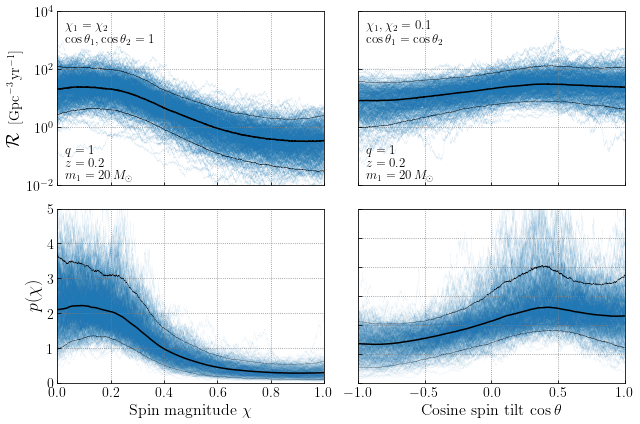

In [30]:
fig = plt.figure(figsize=(9,6))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)

# Convert to dR/dlnm*dq at m1=20 and q=1
p_q1 = (1.+bq)/(1.-(2./20.)**(1.+bq))
dR_dchi_cost1 = R_ref[:,np.newaxis]*f_cost1[:,np.newaxis]**2*f_chis**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dchi_cost1.shape[0]),size=500,replace=False):                 
    ax.plot(chis,dR_dchi_cost1[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='black',lw=0.3)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

dR_dcost_a01 = R_ref[:,np.newaxis]*f_a01[:,np.newaxis]**2*f_costs**2*p_q1[:,np.newaxis]*20.
      
for i in np.random.choice(range(dR_dcost_a01.shape[0]),size=500,replace=False):                 
    ax.plot(costs,dR_dcost_a01[i,:],color='#1f78b4',alpha=0.2,lw=0.2,zorder=0)
    
ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.plot(costs,np.quantile(dR_dcost_a01,0.05,axis=0),color='black',lw=0.3)
ax.plot(costs,np.quantile(dR_dcost_a01,0.95,axis=0),color='black',lw=0.3)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)

p_chi = f_chis/np.trapz(f_chis,chis)[:,np.newaxis]

for i in np.random.choice(range(p_chi.shape[0]),size=500,replace=False):                 
    ax.plot(chis,p_chi[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(chis,np.mean(p_chi,axis=0),color='black')
ax.plot(chis,np.quantile(p_chi,0.05,axis=0),color='black',lw=0.2)
ax.plot(chis,np.quantile(p_chi,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
#ax.set_yscale('log')

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)

p_cost = f_costs/np.trapz(f_costs,costs)[:,np.newaxis]
      
for i in np.random.choice(range(p_cost.shape[0]),size=500,replace=False):                 
    ax.plot(costs,p_cost[i,:],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.plot(costs,np.mean(p_cost,axis=0),color='black')
ax.plot(costs,np.quantile(p_cost,0.05,axis=0),color='black',lw=0.2)
ax.plot(costs,np.quantile(p_cost,0.95,axis=0),color='black',lw=0.2)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)

#plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.tight_layout()
plt.show()

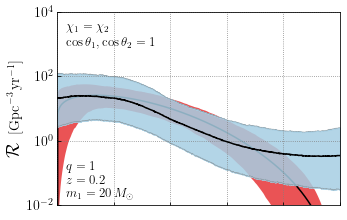

In [58]:
fig = plt.figure(figsize=(9,6))

#########################
ax = fig.add_subplot(221)
ax.set_rasterization_zorder(1)
    
ax.plot(chis,np.median(dR_dchi_cost1,axis=0),color='black')
ax.plot(chis,np.quantile(dR_dchi_cost1,0.05,axis=0),color='grey',lw=0.5,alpha=0.5)
ax.plot(chis,np.quantile(dR_dchi_cost1,0.95,axis=0),color='grey',lw=0.5,alpha=0.5)
ax.fill_between(chis,
                np.quantile(dR_dchi_cost1,0.05,axis=0),
                np.quantile(dR_dchi_cost1,0.95,axis=0),
                color='#a6cee3',alpha=0.85,zorder=-1)

ax.plot(lvk_chi_grid,np.mean(lvk_R_chi,axis=0),color='black',zorder=-2)
#ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.05,axis=0),color='#e31a1c',zorder=1,lw=0.5)
#ax.plot(lvk_chi_grid,np.quantile(lvk_R_chi,0.95,axis=0),color='#e31a1c',zorder=1,lw=0.5)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_R_chi,0.05,axis=0),
                np.quantile(lvk_R_chi,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=-3,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])

ax.text(0.03,0.92,r'$\chi_1 = \chi_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1,\cos\theta_2 = 1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]}',fontsize=18)

#########################
"""ax = fig.add_subplot(222)
ax.set_rasterization_zorder(1)

ax.plot(costs,np.median(dR_dcost_a01,axis=0),color='black')
ax.fill_between(costs,
                np.quantile(dR_dcost_a01,0.05,axis=0),
                np.quantile(dR_dcost_a01,0.95,axis=0),
                color='#1f78b4',alpha=0.75)

ax.plot(lvk_cost_grid,np.mean(lvk_R_cost,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_R_cost,0.05,axis=0),
                np.quantile(lvk_R_cost,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(1e-2,1e4)
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(0.03,0.92,r'$\chi_1,\chi_2=0.1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.84,r'$\cos\theta_1=\cos\theta_2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

ax.text(0.03,0.20,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.13,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)
ax.text(0.03,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=13)

#########################
ax = fig.add_subplot(223)
ax.set_rasterization_zorder(1)
    
ax.plot(chis,np.mean(p_chi,axis=0),color='black')
ax.fill_between(chis,
                np.quantile(p_chi,0.05,axis=0),
                np.quantile(p_chi,0.95,axis=0),
                color='#1f78b4',alpha=0.75)

ax.plot(lvk_chi_grid,np.mean(lvk_p_chis,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_chi_grid,
                np.quantile(lvk_p_chis,0.05,axis=0),
                np.quantile(lvk_p_chis,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
#ax.set_yscale('log')

ax.set_xlabel('Spin magnitude $\chi$',fontsize=16)
ax.set_ylabel(r'$p(\chi)$',fontsize=18)

#########################
ax = fig.add_subplot(224)
ax.set_rasterization_zorder(1)
    
ax.plot(costs,np.mean(p_cost,axis=0),color='black')
ax.fill_between(costs,
                np.quantile(p_cost,0.05,axis=0),
                np.quantile(p_cost,0.95,axis=0),
                color='#1f78b4',alpha=0.75)

ax.plot(lvk_cost_grid,np.mean(lvk_p_costs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_cost_grid,
                np.quantile(lvk_p_costs,0.05,axis=0),
                np.quantile(lvk_p_costs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.tick_params(labelsize=14)
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)
ax.set_yticklabels([])

ax.set_xlabel('Cosine spin tilt $\cos \\theta$',fontsize=16)"""

#plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.tight_layout()
plt.show()

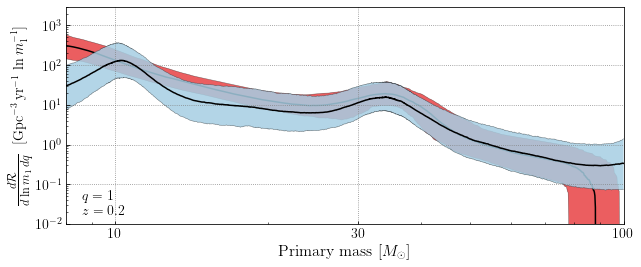

In [5]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

ax.plot(m1s,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.fill_between(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

ax.plot(lvk_m1_grid,np.median(lvk_R_m1s_qs[:,-1,:],axis=0)*lvk_m1_grid,color='black',zorder=-1)
ax.fill_between(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('lnm1_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

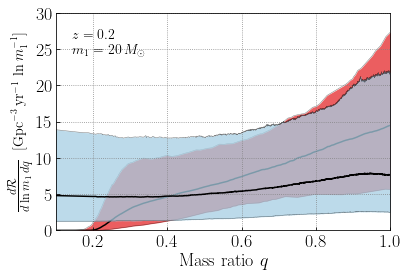

In [199]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.fill_between(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),
                np.quantile(dR_dqs_lnm20,0.95,axis=1),
                color='#a6cee3',lw=0.15,alpha=0.75)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.

ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('q_rate_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

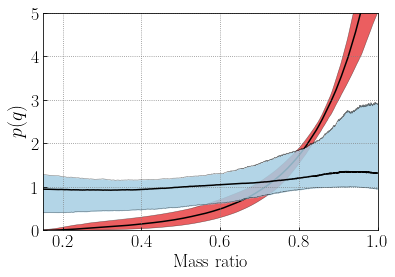

In [66]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.fill_between(qs,np.quantile(p_qs,0.05,axis=1),np.quantile(p_qs,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

lvk_R_qs = np.trapz(lvk_R_m1s_qs,lvk_m1_grid,axis=2)
lvk_p_qs = np.array([lvk_R_qs[i,:]/np.trapz(lvk_R_qs[i,:],lvk_q_grid) for i in range(lvk_R_qs.shape[0])])

ax.plot(lvk_q_grid,np.median(lvk_p_qs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),
                np.quantile(lvk_p_qs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.15,1)
ax.set_ylim(0,5)

ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()